# The Train Problem
___
“A railroad numbers its locomotives in order 1..N. One day you see a locomotive with the number 60. Estimate how many locomotives the railroad has.”

Based on this observation, we know the railroad has 60 or more locomotives. But how many more? To apply Bayesian reasoning, we can break this problem into two steps:

* What did we know about N before we saw the data?

* For any given value of N, what is the likelihood of seeing the data (a locomotive with number 60)?

The answer to the first question is the prior. The answer to the second is the likelihood.

We don’t have much basis to choose a prior, so we’ll start with something simple and then consider alternatives. Let’s assume that N is equally likely to be any value from 1 to 1000.

In [9]:
try:
  import empiricaldist
except:
  !pip install empiricaldist
import numpy as np
import matplotlib.pyplot as plt

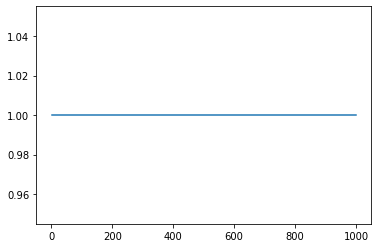

In [18]:
from empiricaldist import Pmf
hypos=np.arange(1,1001)
prior = Pmf(1,hypos)
plt.plot(prior)

Now let’s figure out the likelihood of the data. In a hypothetical fleet of $N$ locomotives, what is the probability that we would see number 60? If we assume that we are equally likely to see any locomotive, the chance of seeing any particular one is $1/N$.

In [19]:
def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs # N
    likelihood = 1 / hypos # 1/N
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [20]:
data = 60 # We have spotted a locomotive numbered 60
posterior = prior.copy()
update_train(posterior, data)
posterior

,probs
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
...,...
996,0.000356
997,0.000355
998,0.000355
999,0.000355


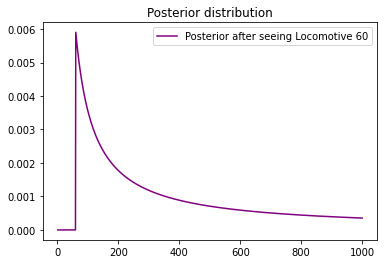

In [21]:
plt.plot(posterior,color='purple')
plt.title("Posterior distribution")
plt.legend(['Posterior after seeing Locomotive 60'])

In [22]:
posterior.max_prob()

60

That might not seem like a very good guess; after all, what are the chances that you just happened to see the train with the highest number? Nevertheless, if you want to maximize the chance of getting the answer exactly right, you should guess 60.

But maybe that’s not the right goal. An alternative is to compute the mean of the posterior distribution. Given a set of possible quantities, $q_i$, and their probabilities, $p_i$, the mean of the distribution is:

\begin{equation}
mean = \sum_i p_iq_i
\end{equation}


In [23]:
summation_i=np.sum(posterior.ps * posterior.qs)
summation_i.mean() # mean of sum 

333.41989326370776

The mean of the posterior is 333, so that might be a good guess if you want to minimize error. If you played this guessing game over and over, using the mean of the posterior as your estimate would minimize the [mean squared error](https://en.wikipedia.org/wiki/Minimum_mean_square_error) over the long run.

# Sensitivity to the prior
The prior used in the previous section is uniform from 1 to 1000, but it offered no justification for choosing a uniform distribution or that particular upper bound. We might wonder whether the posterior distribution is sensitive to the prior. With so little data—only one observation—it is.

This table shows what happens as we vary the upper bound:

In [26]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


As we vary the upper bound, the posterior mean changes substantially. So that’s bad.

When the posterior is sensitive to the prior, there are two ways to proceed:

* Get more data.

* Get more background information and choose a better prior.

With more data, posterior distributions based on different priors tend to converge.
For example, suppose that in addition to train **60** we also see trains **30** and **90**.

Here’s how the posterior means depend on the upper bound of the prior, when we observe three trains:

In [29]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


The differences are smaller, nonetheless three trains are ostensibly inedequate for the posteriors to converge.

# Power Law Prior
___

If more data are not available, another option is to improve the priors by gathering more background information. It is probably not reasonable to assume that a train-operating company with 1000 locomotives is just as likely as a company with only 1.

With some effort, we could probably find a list of companies that operate locomotives in the area of observation. Or we could interview an expert in rail shipping to gather information about the typical size of companies.

But even without getting into the specifics of railroad economics, we can make some educated guesses. In most fields, there are many small companies, fewer medium-sized companies, and only one or two very large companies.

In fact, the distribution of company sizes tends to follow a power law, as Robert Axtell reports in [Science](http://www.sciencemag.org/content/293/5536/1818.full.pdf).

This law suggests that if there are 1000 companies with fewer than 10 locomotives, there might be 100 companies with 100 locomotives, 10 companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a given size, $N$, is proportional to $(1/N)^α$, where $α$ is a parameter that is often near 1.

\begin{equation}
N ∝ (\frac 1N)^α \ [α \to 1.0]
\\= N ∝ N^{-α} 
\end{equation}

We can construct a power law prior like this:

In [30]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

8.178368103610282

In [31]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

In [43]:
def decorate(xlabel=None,ylabel=None,title=None,legend=[]):
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(legend)

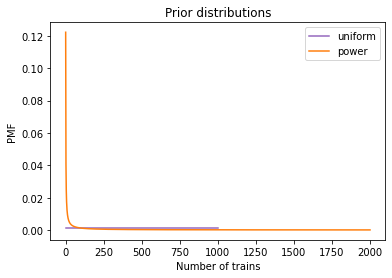

In [45]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions',
         legend=['uniform','power'])

Here’s the update for both priors.

In [46]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

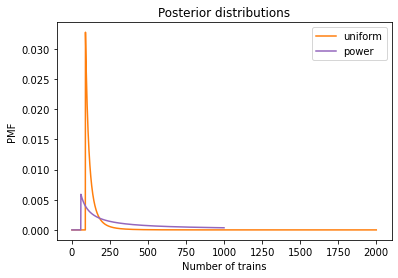

In [56]:
power.plot(color='C1')
uniform.plot(color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions',
         legend=['uniform','power'])

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

Here’s how the posterior means depend on the upper bound when we use a power law prior and observe three trains:

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


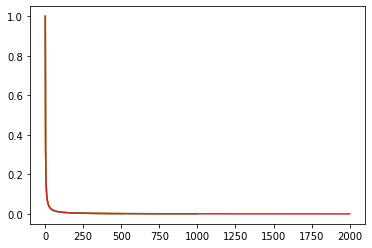

In [61]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]
c=1
for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    power.plot(color=f'C{c}')
    c+=1
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

Now the differences are much smaller. In fact, with an arbitrarily large upper bound, the mean converges on 134.

So the power law **prior is more realistic**, because it is based on general information about the size of companies, and it behaves better in practice.

# Credible Intervals
___

So far we have seen two ways to summarize a posterior distribution: the value with the highest posterior probability (the MAP) and the posterior mean. These are both **point estimates**, that is, single values that estimate the quantity we are interested in.

Another way to summarize a posterior distribution is with percentiles. If you have taken a standardized test, you might be familiar with percentiles. For example, if your score is the 90th percentile, that means you did as well as or better than 90% of the people who took the test.

If we are given a value, `x`, we can compute its percentile rank by finding all values less than or equal to` x `and adding up their probabilities.

Pmf provides a method that does this computation. So, for example, `we can compute the probability that the company has less than or equal to 100` trains:

In [62]:
power.prob_le(100)

0.2937469222495771

With a power law prior and a dataset of three trains, the result is about 29%. So 100 trains is the 29th percentile.

Going the other way, suppose we want to compute a particular percentile; for example, the median of a distribution is the 50th percentile. We can compute it by adding up probabilities until the total exceeds 0.5. Here’s a function that does it:

In [51]:
def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

In [52]:
quantile(power, 0.5)

113

The result, 113 trains, is the median of the posterior distribution.

Pmf provides a method called quantile that does the same thing. We can call it like this to compute the 5th and 95th percentiles:

In [54]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

The result is the interval from 91 to 243 trains, which implies:

* The probability is 5% that the number of trains is less than or equal to 91.

* The probability is 5% that the number of trains is greater than 243.

Therefore the probability is 90% that the number of trains falls between 91 and 243 (excluding 91 and including 243). For this reason, this interval is called a 90% credible interval.

Pmf also provides credible_interval, which computes an interval that contains the given probability.

In [55]:
power.credible_interval(0.9)

array([ 91., 243.])

# The German Tank Problem
___
During World War II, the Economic Warfare Division of the American Embassy in London used statistical analysis to estimate German production of tanks and other equipment.

The Western Allies had captured log books, inventories, and repair records that included chassis and engine serial numbers for individual tanks.

Analysis of these records indicated that serial numbers were allocated by manufacturer and tank type in blocks of 100 numbers, that numbers in each block were used sequentially, and that not all numbers in each block were used. So the problem of estimating German tank production could be reduced, within each block of 100 numbers, to a form of the train problem.

Based on this insight, American and British analysts produced estimates substantially lower than estimates from other forms of intelligence. And after the war, records indicated that they were substantially more accurate.

They performed similar analyses for tires, trucks, rockets, and other equipment, yielding accurate and actionable economic intelligence.

The German tank problem is historically interesting; it is also a nice example of real-world application of statistical estimation.

For more on this problem, see [this Wikipedia page](https://en.wikipedia.org/wiki/German_tank_problem) and Ruggles and Brodie, “An Empirical Approach to Economic Intelligence in World War II”, Journal of the American Statistical Association, March 1947, available [here](https://web.archive.org/web/20170123132042/https://www.cia.gov/library/readingroom/docs/CIA-RDP79R01001A001300010013-3.pdf).

# Informative Priors
___
Among Bayesians, there are two approaches to choosing prior distributions. Some recommend choosing the prior that best represents background information about the problem; in that case the prior is said to be informative. The **problem with using an informative prior** is that people might have different information or interpret it differently. So **informative priors** might seem arbitrary.

The alternative is a so-called **uninformative prior**, which is intended to be as unrestricted as possible, in order to let the data speak for itself. In some cases you can identify a unique prior that has some desirable property, like representing minimal prior information about the estimated quantity.

**Uninformative priors are appealing because** they seem more objective. But **I am generally in favor of using informative priors**. Why? First, Bayesian analysis is **always based on modeling decisions**. Choosing the prior is one of those decisions, but it is not the only one, and it might not even be the most subjective. So even if an uninformative prior is more objective, the entire analysis is still subjective.

Also, for most practical problems, you are likely to be in one of two situations: either you have a lot of data or not very much. If you have a lot of data, the choice of the prior doesn’t matter; informative and uninformative priors yield almost the same results. If you don’t have much data, using relevant background information (like the power law distribution) makes a big difference.

And if, as in the German tank problem, you have to make life and death decisions based on your results, you should probably use all of the information at your disposal, rather than maintaining the illusion of objectivity by pretending to know less than you do.

### **Remarks**

* If we have limited information and an infinite number of possibilities, updating a uniform prior becomes obsolete.
* In that case the mean of posterior distribution could give us a better chance of guessing the highest number in a distribution.
* But the mean is proven to be Sensitive to Prior and that being proportional to the highest number in the distribution.
* That's where the ***Power Law Prior*** comes in. Which gives us a lower posterior mean and is less sensitive to prior. Hence, the posterior is more likely to converge in any given prior distribution.
* Bayesian analysis is based on modeling decisions and choosing the prior is one of those decisions. If you have a lot of data, the choice of prior doesn't matter, because they yield almost identical results. In contrast, when you don't have much data, then a distribution like the **power law prior**, comes in handy.